In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "2" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

In [5]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)


br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [6]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    
ep=311
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
ncluster=8
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+'_plottingIdx_progBalanced_'+str(i)
with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [7]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [8]:
#load NMCO
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
allvarnames=None
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'nmco_features',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s):
        print('DNE '+path_s)
    print(s)
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0

    stats_s=pd.read_csv(path_s)
    stats_s.index=stats_s.loc[:,'label']
    stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s]].to_numpy()[:,2:-2]
    print(stats_s.shape)


#         ssplit=s.split('_')
    slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]

    if allstats is None:
        allstats=stats_s
        alllabels=np.copy(slabels)
    else:
        allstats=np.concatenate((allstats,stats_s),axis=0)
        alllabels=np.concatenate((alllabels,np.copy(slabels)))


br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
(380, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
(508, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
(360, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
(358, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
(525, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
(314, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
(862, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
(484, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
(2997, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
(773, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
(1286, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
(1131, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
(2694, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5
(954, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6
(780, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7
(667, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C8
(392, 201)
br1003a_1_cytokeratin_555_

(276, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F10
(312, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F2
(302, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F3
(227, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F4
(395, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F5
(169, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F6
(289, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F7
(308, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F8
(472, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F9
(358, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H1
(816, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H2
(3293, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H3
(2464, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H4
(1920, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H5
(1439, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H6
(2562, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H7
(1716, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H8
(2838, 201)
br8018a_3_co

In [9]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allstats.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allstats.shape[0])]
testIdx=allIdx[int(pctVal*allstats.shape[0]):(int(pctVal*allstats.shape[0])+int(pctTest*allstats.shape[0]))]
trainIdx=allIdx[(int(pctVal*allstats.shape[0])+int(pctTest*allstats.shape[0])):]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

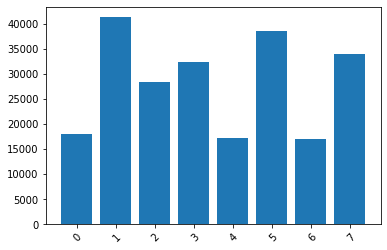

In [10]:
trainLabels,traincounts=np.unique(alllabels[trainIdx],return_counts=True)
fig, ax = plt.subplots()
plt.bar(trainLabels,traincounts)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

In [11]:
weightClf=np.zeros(traincounts.size)
for i in range(traincounts.size):
    weightClf[i]=np.sum(traincounts)/traincounts[i]/10

In [12]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=128
fc_dim2=128
fc_dim3=128


dropout=0.01
kl_weight=0.0000001

name='exp0_clusterClf_nmco_'+savenamecluster+'fcl3'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [13]:
# Create model
seed=3
torch.manual_seed(seed)
nclasses=np.unique(alllabels).size
if use_cuda:
    torch.cuda.manual_seed(seed)
    
if model_str=='fc3':
    model = modelsCNN.FC_l3(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
if model_str=='fc5':
    model = modelsCNN.FC_l5(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
if model_str=='fc1':
    model = modelsCNN.FC_l1(allstats.shape[1],fc_dim1,nclasses,regrs=False)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
if model_str=='fc0':
    model = modelsCNN.FC_l0(allstats.shape[1],nclasses,regrs=False)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())



if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [14]:
allstats=allstats.astype(float)
allstats=scipy.stats.zscore(allstats,axis=0,nan_policy='omit')
allstats=np.nan_to_num(allstats,nan=0)

In [15]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(allstats[trainIdx_i]).cuda().float()
            labels=torch.tensor(alllabels[trainIdx_i]).cuda().long()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred,labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(allstats[valIdx_i]).cuda().float()
                labels=torch.tensor(alllabels[valIdx_i]).cuda().long()
                
            pred= model(valInput)

            loss_val=lossCE(pred,labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == 0 and ep!=0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


Epoch: 0000 loss_train: 1.6300 loss_val: 1.0792
Epoch: 0001 loss_train: 0.8536 loss_val: 0.3962
Epoch: 0002 loss_train: 0.4799 loss_val: 0.2305
Epoch: 0003 loss_train: 0.3736 loss_val: 0.1922
Epoch: 0004 loss_train: 0.3266 loss_val: 0.1767
Epoch: 0005 loss_train: 0.2999 loss_val: 0.1592
Epoch: 0006 loss_train: 0.2760 loss_val: 0.1486
Epoch: 0007 loss_train: 0.2586 loss_val: 0.1413
Epoch: 0008 loss_train: 0.2470 loss_val: 0.1375
Epoch: 0009 loss_train: 0.2363 loss_val: 0.1293
Epoch: 0010 loss_train: 0.2284 loss_val: 0.1259
Epoch: 0011 loss_train: 0.2210 loss_val: 0.1225
Epoch: 0012 loss_train: 0.2101 loss_val: 0.1177
Epoch: 0013 loss_train: 0.2055 loss_val: 0.1158
Epoch: 0014 loss_train: 0.2013 loss_val: 0.1138
Epoch: 0015 loss_train: 0.1936 loss_val: 0.1120
Epoch: 0016 loss_train: 0.1907 loss_val: 0.1096
Epoch: 0017 loss_train: 0.1851 loss_val: 0.1075
Epoch: 0018 loss_train: 0.1818 loss_val: 0.1060
Epoch: 0019 loss_train: 0.1775 loss_val: 0.1025
Epoch: 0020 loss_train: 0.1739 loss_val:

Epoch: 0171 loss_train: 0.0925 loss_val: 0.0643
Epoch: 0172 loss_train: 0.0921 loss_val: 0.0635
Epoch: 0173 loss_train: 0.0925 loss_val: 0.0660
Epoch: 0174 loss_train: 0.0925 loss_val: 0.0634
Epoch: 0175 loss_train: 0.0921 loss_val: 0.0634
Epoch: 0176 loss_train: 0.0924 loss_val: 0.0641
Epoch: 0177 loss_train: 0.0915 loss_val: 0.0649
Epoch: 0178 loss_train: 0.0921 loss_val: 0.0615
Epoch: 0179 loss_train: 0.0911 loss_val: 0.0634
Epoch: 0180 loss_train: 0.0923 loss_val: 0.0644
Epoch: 0181 loss_train: 0.0895 loss_val: 0.0632
Epoch: 0182 loss_train: 0.0926 loss_val: 0.0668
Epoch: 0183 loss_train: 0.0915 loss_val: 0.0630
Epoch: 0184 loss_train: 0.0907 loss_val: 0.0619
Epoch: 0185 loss_train: 0.0910 loss_val: 0.0633
Epoch: 0186 loss_train: 0.0924 loss_val: 0.0623
Epoch: 0187 loss_train: 0.0914 loss_val: 0.0625
Epoch: 0188 loss_train: 0.0914 loss_val: 0.0668
Epoch: 0189 loss_train: 0.0916 loss_val: 0.0626
Epoch: 0190 loss_train: 0.0898 loss_val: 0.0642
Epoch: 0191 loss_train: 0.0909 loss_val:

Epoch: 0342 loss_train: 0.0823 loss_val: 0.0579
Epoch: 0343 loss_train: 0.0805 loss_val: 0.0587
Epoch: 0344 loss_train: 0.0816 loss_val: 0.0584
Epoch: 0345 loss_train: 0.0809 loss_val: 0.0588
Epoch: 0346 loss_train: 0.0807 loss_val: 0.0582
Epoch: 0347 loss_train: 0.0821 loss_val: 0.0582
Epoch: 0348 loss_train: 0.0811 loss_val: 0.0591
Epoch: 0349 loss_train: 0.0810 loss_val: 0.0595
Epoch: 0350 loss_train: 0.0807 loss_val: 0.0594
Epoch: 0351 loss_train: 0.0808 loss_val: 0.0590
Epoch: 0352 loss_train: 0.0823 loss_val: 0.0594
Epoch: 0353 loss_train: 0.0819 loss_val: 0.0601
Epoch: 0354 loss_train: 0.0797 loss_val: 0.0586
Epoch: 0355 loss_train: 0.0804 loss_val: 0.0573
Epoch: 0356 loss_train: 0.0802 loss_val: 0.0581
Epoch: 0357 loss_train: 0.0813 loss_val: 0.0573
Epoch: 0358 loss_train: 0.0808 loss_val: 0.0600
Epoch: 0359 loss_train: 0.0798 loss_val: 0.0590
Epoch: 0360 loss_train: 0.0809 loss_val: 0.0605
Epoch: 0361 loss_train: 0.0809 loss_val: 0.0592
Epoch: 0362 loss_train: 0.0807 loss_val:

Epoch: 0513 loss_train: 0.0761 loss_val: 0.0573
Epoch: 0514 loss_train: 0.0750 loss_val: 0.0567
Epoch: 0515 loss_train: 0.0765 loss_val: 0.0568
Epoch: 0516 loss_train: 0.0756 loss_val: 0.0573
Epoch: 0517 loss_train: 0.0763 loss_val: 0.0583
Epoch: 0518 loss_train: 0.0757 loss_val: 0.0583
Epoch: 0519 loss_train: 0.0754 loss_val: 0.0568
Epoch: 0520 loss_train: 0.0765 loss_val: 0.0606
Epoch: 0521 loss_train: 0.0755 loss_val: 0.0574
Epoch: 0522 loss_train: 0.0752 loss_val: 0.0573
Epoch: 0523 loss_train: 0.0740 loss_val: 0.0581
Epoch: 0524 loss_train: 0.0752 loss_val: 0.0565
Epoch: 0525 loss_train: 0.0759 loss_val: 0.0577
Epoch: 0526 loss_train: 0.0754 loss_val: 0.0559
Epoch: 0527 loss_train: 0.0751 loss_val: 0.0581
Epoch: 0528 loss_train: 0.0763 loss_val: 0.0563
Epoch: 0529 loss_train: 0.0764 loss_val: 0.0578
Epoch: 0530 loss_train: 0.0777 loss_val: 0.0571
Epoch: 0531 loss_train: 0.0760 loss_val: 0.0564
Epoch: 0532 loss_train: 0.0754 loss_val: 0.0563
Epoch: 0533 loss_train: 0.0751 loss_val:

Epoch: 0684 loss_train: 0.0732 loss_val: 0.0547
Epoch: 0685 loss_train: 0.0717 loss_val: 0.0569
Epoch: 0686 loss_train: 0.0729 loss_val: 0.0591
Epoch: 0687 loss_train: 0.0731 loss_val: 0.0569
Epoch: 0688 loss_train: 0.0717 loss_val: 0.0547
Epoch: 0689 loss_train: 0.0721 loss_val: 0.0571
Epoch: 0690 loss_train: 0.0721 loss_val: 0.0556
Epoch: 0691 loss_train: 0.0713 loss_val: 0.0585
Epoch: 0692 loss_train: 0.0734 loss_val: 0.0574
Epoch: 0693 loss_train: 0.0730 loss_val: 0.0575
Epoch: 0694 loss_train: 0.0727 loss_val: 0.0544
Epoch: 0695 loss_train: 0.0733 loss_val: 0.0558
Epoch: 0696 loss_train: 0.0726 loss_val: 0.0557
Epoch: 0697 loss_train: 0.0734 loss_val: 0.0578
Epoch: 0698 loss_train: 0.0737 loss_val: 0.0558
Epoch: 0699 loss_train: 0.0724 loss_val: 0.0544
Epoch: 0700 loss_train: 0.0727 loss_val: 0.0562
Epoch: 0701 loss_train: 0.0728 loss_val: 0.0570
Epoch: 0702 loss_train: 0.0728 loss_val: 0.0551
Epoch: 0703 loss_train: 0.0720 loss_val: 0.0555
Epoch: 0704 loss_train: 0.0744 loss_val:

Epoch: 0855 loss_train: 0.0714 loss_val: 0.0554
Epoch: 0856 loss_train: 0.0719 loss_val: 0.0550
Epoch: 0857 loss_train: 0.0707 loss_val: 0.0550
Epoch: 0858 loss_train: 0.0706 loss_val: 0.0552
Epoch: 0859 loss_train: 0.0697 loss_val: 0.0527
Epoch: 0860 loss_train: 0.0702 loss_val: 0.0549
Epoch: 0861 loss_train: 0.0701 loss_val: 0.0543
Epoch: 0862 loss_train: 0.0695 loss_val: 0.0554
Epoch: 0863 loss_train: 0.0719 loss_val: 0.0561
Epoch: 0864 loss_train: 0.0703 loss_val: 0.0554
Epoch: 0865 loss_train: 0.0693 loss_val: 0.0531
Epoch: 0866 loss_train: 0.0696 loss_val: 0.0551
Epoch: 0867 loss_train: 0.0712 loss_val: 0.0548
Epoch: 0868 loss_train: 0.0705 loss_val: 0.0562
Epoch: 0869 loss_train: 0.0705 loss_val: 0.0555
Epoch: 0870 loss_train: 0.0693 loss_val: 0.0544
Epoch: 0871 loss_train: 0.0696 loss_val: 0.0559
Epoch: 0872 loss_train: 0.0706 loss_val: 0.0543
Epoch: 0873 loss_train: 0.0709 loss_val: 0.0554
Epoch: 0874 loss_train: 0.0706 loss_val: 0.0564
Epoch: 0875 loss_train: 0.0704 loss_val:

Epoch: 1026 loss_train: 0.0685 loss_val: 0.0562
Epoch: 1027 loss_train: 0.0686 loss_val: 0.0562
Epoch: 1028 loss_train: 0.0680 loss_val: 0.0579
Epoch: 1029 loss_train: 0.0700 loss_val: 0.0569
Epoch: 1030 loss_train: 0.0684 loss_val: 0.0546
Epoch: 1031 loss_train: 0.0675 loss_val: 0.0571
Epoch: 1032 loss_train: 0.0692 loss_val: 0.0549
Epoch: 1033 loss_train: 0.0697 loss_val: 0.0565
Epoch: 1034 loss_train: 0.0695 loss_val: 0.0556
Epoch: 1035 loss_train: 0.0683 loss_val: 0.0543
Epoch: 1036 loss_train: 0.0676 loss_val: 0.0539
Epoch: 1037 loss_train: 0.0686 loss_val: 0.0550
Epoch: 1038 loss_train: 0.0684 loss_val: 0.0542
Epoch: 1039 loss_train: 0.0690 loss_val: 0.0558
Epoch: 1040 loss_train: 0.0676 loss_val: 0.0560
Epoch: 1041 loss_train: 0.0691 loss_val: 0.0553
Epoch: 1042 loss_train: 0.0696 loss_val: 0.0560
Epoch: 1043 loss_train: 0.0700 loss_val: 0.0569
Epoch: 1044 loss_train: 0.0698 loss_val: 0.0543
Epoch: 1045 loss_train: 0.0691 loss_val: 0.0556
Epoch: 1046 loss_train: 0.0682 loss_val:

Epoch: 1197 loss_train: 0.0664 loss_val: 0.0552
Epoch: 1198 loss_train: 0.0674 loss_val: 0.0530
Epoch: 1199 loss_train: 0.0686 loss_val: 0.0558
Epoch: 1200 loss_train: 0.0672 loss_val: 0.0546
Epoch: 1201 loss_train: 0.0690 loss_val: 0.0566
Epoch: 1202 loss_train: 0.0675 loss_val: 0.0548
Epoch: 1203 loss_train: 0.0675 loss_val: 0.0546
Epoch: 1204 loss_train: 0.0684 loss_val: 0.0555
Epoch: 1205 loss_train: 0.0674 loss_val: 0.0539
Epoch: 1206 loss_train: 0.0681 loss_val: 0.0571
Epoch: 1207 loss_train: 0.0679 loss_val: 0.0568
Epoch: 1208 loss_train: 0.0668 loss_val: 0.0547
Epoch: 1209 loss_train: 0.0664 loss_val: 0.0547
Epoch: 1210 loss_train: 0.0676 loss_val: 0.0541
Epoch: 1211 loss_train: 0.0672 loss_val: 0.0554
Epoch: 1212 loss_train: 0.0677 loss_val: 0.0561
Epoch: 1213 loss_train: 0.0687 loss_val: 0.0555
Epoch: 1214 loss_train: 0.0670 loss_val: 0.0556
Epoch: 1215 loss_train: 0.0673 loss_val: 0.0565
Epoch: 1216 loss_train: 0.0686 loss_val: 0.0562
Epoch: 1217 loss_train: 0.0679 loss_val:

Epoch: 1368 loss_train: 0.0656 loss_val: 0.0565
Epoch: 1369 loss_train: 0.0664 loss_val: 0.0559
Epoch: 1370 loss_train: 0.0665 loss_val: 0.0564
Epoch: 1371 loss_train: 0.0662 loss_val: 0.0562
Epoch: 1372 loss_train: 0.0666 loss_val: 0.0565
Epoch: 1373 loss_train: 0.0660 loss_val: 0.0554
Epoch: 1374 loss_train: 0.0675 loss_val: 0.0559
Epoch: 1375 loss_train: 0.0658 loss_val: 0.0568
Epoch: 1376 loss_train: 0.0667 loss_val: 0.0563
Epoch: 1377 loss_train: 0.0667 loss_val: 0.0564
Epoch: 1378 loss_train: 0.0654 loss_val: 0.0557
Epoch: 1379 loss_train: 0.0665 loss_val: 0.0544
Epoch: 1380 loss_train: 0.0654 loss_val: 0.0551
Epoch: 1381 loss_train: 0.0658 loss_val: 0.0569
Epoch: 1382 loss_train: 0.0670 loss_val: 0.0569
Epoch: 1383 loss_train: 0.0669 loss_val: 0.0565
Epoch: 1384 loss_train: 0.0654 loss_val: 0.0571
Epoch: 1385 loss_train: 0.0670 loss_val: 0.0565
Epoch: 1386 loss_train: 0.0668 loss_val: 0.0558
Epoch: 1387 loss_train: 0.0672 loss_val: 0.0554
Epoch: 1388 loss_train: 0.0664 loss_val:

Epoch: 1539 loss_train: 0.0654 loss_val: 0.0569
Epoch: 1540 loss_train: 0.0660 loss_val: 0.0551
Epoch: 1541 loss_train: 0.0657 loss_val: 0.0573
Epoch: 1542 loss_train: 0.0660 loss_val: 0.0560
Epoch: 1543 loss_train: 0.0655 loss_val: 0.0537
Epoch: 1544 loss_train: 0.0647 loss_val: 0.0536
Epoch: 1545 loss_train: 0.0645 loss_val: 0.0543
Epoch: 1546 loss_train: 0.0644 loss_val: 0.0550
Epoch: 1547 loss_train: 0.0640 loss_val: 0.0529
Epoch: 1548 loss_train: 0.0643 loss_val: 0.0551
Epoch: 1549 loss_train: 0.0653 loss_val: 0.0538
Epoch: 1550 loss_train: 0.0646 loss_val: 0.0541
Epoch: 1551 loss_train: 0.0649 loss_val: 0.0546
Epoch: 1552 loss_train: 0.0652 loss_val: 0.0540
Epoch: 1553 loss_train: 0.0641 loss_val: 0.0555
Epoch: 1554 loss_train: 0.0650 loss_val: 0.0549
Epoch: 1555 loss_train: 0.0648 loss_val: 0.0544
Epoch: 1556 loss_train: 0.0644 loss_val: 0.0566
Epoch: 1557 loss_train: 0.0656 loss_val: 0.0555
Epoch: 1558 loss_train: 0.0666 loss_val: 0.0551
Epoch: 1559 loss_train: 0.0646 loss_val:

Epoch: 1710 loss_train: 0.0653 loss_val: 0.0531
Epoch: 1711 loss_train: 0.0659 loss_val: 0.0545
Epoch: 1712 loss_train: 0.0658 loss_val: 0.0549
Epoch: 1713 loss_train: 0.0662 loss_val: 0.0551
Epoch: 1714 loss_train: 0.0651 loss_val: 0.0553
Epoch: 1715 loss_train: 0.0637 loss_val: 0.0533
Epoch: 1716 loss_train: 0.0636 loss_val: 0.0530
Epoch: 1717 loss_train: 0.0644 loss_val: 0.0525
Epoch: 1718 loss_train: 0.0647 loss_val: 0.0560
Epoch: 1719 loss_train: 0.0639 loss_val: 0.0544
Epoch: 1720 loss_train: 0.0651 loss_val: 0.0539
Epoch: 1721 loss_train: 0.0647 loss_val: 0.0544
Epoch: 1722 loss_train: 0.0655 loss_val: 0.0538
Epoch: 1723 loss_train: 0.0649 loss_val: 0.0544
Epoch: 1724 loss_train: 0.0655 loss_val: 0.0543
Epoch: 1725 loss_train: 0.0647 loss_val: 0.0528
Epoch: 1726 loss_train: 0.0649 loss_val: 0.0551
Epoch: 1727 loss_train: 0.0649 loss_val: 0.0548
Epoch: 1728 loss_train: 0.0636 loss_val: 0.0548
Epoch: 1729 loss_train: 0.0655 loss_val: 0.0567
Epoch: 1730 loss_train: 0.0635 loss_val:

Epoch: 1881 loss_train: 0.0627 loss_val: 0.0548
Epoch: 1882 loss_train: 0.0630 loss_val: 0.0535
Epoch: 1883 loss_train: 0.0637 loss_val: 0.0564
Epoch: 1884 loss_train: 0.0641 loss_val: 0.0535
Epoch: 1885 loss_train: 0.0641 loss_val: 0.0535
Epoch: 1886 loss_train: 0.0635 loss_val: 0.0561
Epoch: 1887 loss_train: 0.0645 loss_val: 0.0557
Epoch: 1888 loss_train: 0.0647 loss_val: 0.0553
Epoch: 1889 loss_train: 0.0636 loss_val: 0.0556
Epoch: 1890 loss_train: 0.0633 loss_val: 0.0532
Epoch: 1891 loss_train: 0.0646 loss_val: 0.0569
Epoch: 1892 loss_train: 0.0647 loss_val: 0.0557
Epoch: 1893 loss_train: 0.0635 loss_val: 0.0548
Epoch: 1894 loss_train: 0.0637 loss_val: 0.0539
Epoch: 1895 loss_train: 0.0622 loss_val: 0.0560
Epoch: 1896 loss_train: 0.0640 loss_val: 0.0560
Epoch: 1897 loss_train: 0.0635 loss_val: 0.0550
Epoch: 1898 loss_train: 0.0626 loss_val: 0.0553
Epoch: 1899 loss_train: 0.0616 loss_val: 0.0558
Epoch: 1900 loss_train: 0.0643 loss_val: 0.0537
Epoch: 1901 loss_train: 0.0638 loss_val:

Epoch: 2052 loss_train: 0.0631 loss_val: 0.0567
Epoch: 2053 loss_train: 0.0635 loss_val: 0.0572
Epoch: 2054 loss_train: 0.0616 loss_val: 0.0560
Epoch: 2055 loss_train: 0.0632 loss_val: 0.0563
Epoch: 2056 loss_train: 0.0630 loss_val: 0.0565
Epoch: 2057 loss_train: 0.0646 loss_val: 0.0574
Epoch: 2058 loss_train: 0.0633 loss_val: 0.0562
Epoch: 2059 loss_train: 0.0634 loss_val: 0.0577
Epoch: 2060 loss_train: 0.0634 loss_val: 0.0574
Epoch: 2061 loss_train: 0.0623 loss_val: 0.0547
Epoch: 2062 loss_train: 0.0634 loss_val: 0.0570
Epoch: 2063 loss_train: 0.0639 loss_val: 0.0560
Epoch: 2064 loss_train: 0.0633 loss_val: 0.0551
Epoch: 2065 loss_train: 0.0631 loss_val: 0.0559
Epoch: 2066 loss_train: 0.0637 loss_val: 0.0563
Epoch: 2067 loss_train: 0.0637 loss_val: 0.0581
Epoch: 2068 loss_train: 0.0632 loss_val: 0.0576
Epoch: 2069 loss_train: 0.0627 loss_val: 0.0547
Epoch: 2070 loss_train: 0.0618 loss_val: 0.0581
Epoch: 2071 loss_train: 0.0610 loss_val: 0.0557
Epoch: 2072 loss_train: 0.0615 loss_val:

Epoch: 2223 loss_train: 0.0616 loss_val: 0.0563
Epoch: 2224 loss_train: 0.0619 loss_val: 0.0572
Epoch: 2225 loss_train: 0.0622 loss_val: 0.0575
Epoch: 2226 loss_train: 0.0634 loss_val: 0.0551
Epoch: 2227 loss_train: 0.0614 loss_val: 0.0535
Epoch: 2228 loss_train: 0.0617 loss_val: 0.0563
Epoch: 2229 loss_train: 0.0612 loss_val: 0.0565
Epoch: 2230 loss_train: 0.0610 loss_val: 0.0547
Epoch: 2231 loss_train: 0.0614 loss_val: 0.0550
Epoch: 2232 loss_train: 0.0608 loss_val: 0.0551
Epoch: 2233 loss_train: 0.0606 loss_val: 0.0580
Epoch: 2234 loss_train: 0.0630 loss_val: 0.0544
Epoch: 2235 loss_train: 0.0615 loss_val: 0.0560
Epoch: 2236 loss_train: 0.0618 loss_val: 0.0561
Epoch: 2237 loss_train: 0.0625 loss_val: 0.0563
Epoch: 2238 loss_train: 0.0611 loss_val: 0.0553
Epoch: 2239 loss_train: 0.0614 loss_val: 0.0559
Epoch: 2240 loss_train: 0.0611 loss_val: 0.0551
Epoch: 2241 loss_train: 0.0611 loss_val: 0.0533
Epoch: 2242 loss_train: 0.0602 loss_val: 0.0546
Epoch: 2243 loss_train: 0.0612 loss_val:

Epoch: 2394 loss_train: 0.0608 loss_val: 0.0550
Epoch: 2395 loss_train: 0.0617 loss_val: 0.0559
Epoch: 2396 loss_train: 0.0624 loss_val: 0.0561
Epoch: 2397 loss_train: 0.0618 loss_val: 0.0544
Epoch: 2398 loss_train: 0.0615 loss_val: 0.0568
Epoch: 2399 loss_train: 0.0629 loss_val: 0.0543
Epoch: 2400 loss_train: 0.0616 loss_val: 0.0559
Epoch: 2401 loss_train: 0.0622 loss_val: 0.0549
Epoch: 2402 loss_train: 0.0624 loss_val: 0.0557
Epoch: 2403 loss_train: 0.0609 loss_val: 0.0552
Epoch: 2404 loss_train: 0.0617 loss_val: 0.0563
Epoch: 2405 loss_train: 0.0630 loss_val: 0.0569
Epoch: 2406 loss_train: 0.0627 loss_val: 0.0548
Epoch: 2407 loss_train: 0.0618 loss_val: 0.0569
Epoch: 2408 loss_train: 0.0609 loss_val: 0.0556
Epoch: 2409 loss_train: 0.0607 loss_val: 0.0542
Epoch: 2410 loss_train: 0.0624 loss_val: 0.0539
Epoch: 2411 loss_train: 0.0623 loss_val: 0.0539
Epoch: 2412 loss_train: 0.0620 loss_val: 0.0539
Epoch: 2413 loss_train: 0.0616 loss_val: 0.0577
Epoch: 2414 loss_train: 0.0613 loss_val:

Epoch: 2565 loss_train: 0.0607 loss_val: 0.0563
Epoch: 2566 loss_train: 0.0600 loss_val: 0.0557
Epoch: 2567 loss_train: 0.0608 loss_val: 0.0553
Epoch: 2568 loss_train: 0.0612 loss_val: 0.0552
Epoch: 2569 loss_train: 0.0614 loss_val: 0.0544
Epoch: 2570 loss_train: 0.0591 loss_val: 0.0548
Epoch: 2571 loss_train: 0.0597 loss_val: 0.0560
Epoch: 2572 loss_train: 0.0613 loss_val: 0.0545
Epoch: 2573 loss_train: 0.0598 loss_val: 0.0543
Epoch: 2574 loss_train: 0.0610 loss_val: 0.0559
Epoch: 2575 loss_train: 0.0614 loss_val: 0.0547
Epoch: 2576 loss_train: 0.0603 loss_val: 0.0545
Epoch: 2577 loss_train: 0.0600 loss_val: 0.0546
Epoch: 2578 loss_train: 0.0612 loss_val: 0.0570
Epoch: 2579 loss_train: 0.0607 loss_val: 0.0547
Epoch: 2580 loss_train: 0.0616 loss_val: 0.0532
Epoch: 2581 loss_train: 0.0613 loss_val: 0.0559
Epoch: 2582 loss_train: 0.0603 loss_val: 0.0547
Epoch: 2583 loss_train: 0.0613 loss_val: 0.0538
Epoch: 2584 loss_train: 0.0616 loss_val: 0.0541
Epoch: 2585 loss_train: 0.0613 loss_val:

Epoch: 2736 loss_train: 0.0603 loss_val: 0.0544
Epoch: 2737 loss_train: 0.0596 loss_val: 0.0552
Epoch: 2738 loss_train: 0.0595 loss_val: 0.0560
Epoch: 2739 loss_train: 0.0597 loss_val: 0.0546
Epoch: 2740 loss_train: 0.0602 loss_val: 0.0559
Epoch: 2741 loss_train: 0.0601 loss_val: 0.0561
Epoch: 2742 loss_train: 0.0586 loss_val: 0.0546
Epoch: 2743 loss_train: 0.0597 loss_val: 0.0553
Epoch: 2744 loss_train: 0.0593 loss_val: 0.0554
Epoch: 2745 loss_train: 0.0592 loss_val: 0.0562
Epoch: 2746 loss_train: 0.0604 loss_val: 0.0536
Epoch: 2747 loss_train: 0.0600 loss_val: 0.0544
Epoch: 2748 loss_train: 0.0603 loss_val: 0.0540
Epoch: 2749 loss_train: 0.0601 loss_val: 0.0558
Epoch: 2750 loss_train: 0.0603 loss_val: 0.0564
Epoch: 2751 loss_train: 0.0600 loss_val: 0.0550
Epoch: 2752 loss_train: 0.0605 loss_val: 0.0551
Epoch: 2753 loss_train: 0.0591 loss_val: 0.0546
Epoch: 2754 loss_train: 0.0591 loss_val: 0.0553
Epoch: 2755 loss_train: 0.0597 loss_val: 0.0532
Epoch: 2756 loss_train: 0.0599 loss_val:

Epoch: 2907 loss_train: 0.0599 loss_val: 0.0590
Epoch: 2908 loss_train: 0.0602 loss_val: 0.0586
Epoch: 2909 loss_train: 0.0598 loss_val: 0.0560
Epoch: 2910 loss_train: 0.0603 loss_val: 0.0559
Epoch: 2911 loss_train: 0.0602 loss_val: 0.0574
Epoch: 2912 loss_train: 0.0602 loss_val: 0.0583
Epoch: 2913 loss_train: 0.0594 loss_val: 0.0578
Epoch: 2914 loss_train: 0.0602 loss_val: 0.0570
Epoch: 2915 loss_train: 0.0594 loss_val: 0.0580
Epoch: 2916 loss_train: 0.0592 loss_val: 0.0558
Epoch: 2917 loss_train: 0.0596 loss_val: 0.0578
Epoch: 2918 loss_train: 0.0599 loss_val: 0.0584
Epoch: 2919 loss_train: 0.0599 loss_val: 0.0581
Epoch: 2920 loss_train: 0.0617 loss_val: 0.0555
Epoch: 2921 loss_train: 0.0613 loss_val: 0.0554
Epoch: 2922 loss_train: 0.0621 loss_val: 0.0589
Epoch: 2923 loss_train: 0.0602 loss_val: 0.0560
Epoch: 2924 loss_train: 0.0598 loss_val: 0.0559
Epoch: 2925 loss_train: 0.0603 loss_val: 0.0559
Epoch: 2926 loss_train: 0.0598 loss_val: 0.0568
Epoch: 2927 loss_train: 0.0591 loss_val:

Epoch: 3078 loss_train: 0.0587 loss_val: 0.0571
Epoch: 3079 loss_train: 0.0580 loss_val: 0.0588
Epoch: 3080 loss_train: 0.0604 loss_val: 0.0570
Epoch: 3081 loss_train: 0.0609 loss_val: 0.0594
Epoch: 3082 loss_train: 0.0603 loss_val: 0.0598
Epoch: 3083 loss_train: 0.0599 loss_val: 0.0590
Epoch: 3084 loss_train: 0.0604 loss_val: 0.0580
Epoch: 3085 loss_train: 0.0578 loss_val: 0.0567
Epoch: 3086 loss_train: 0.0579 loss_val: 0.0562
Epoch: 3087 loss_train: 0.0576 loss_val: 0.0576
Epoch: 3088 loss_train: 0.0587 loss_val: 0.0573
Epoch: 3089 loss_train: 0.0579 loss_val: 0.0577
Epoch: 3090 loss_train: 0.0583 loss_val: 0.0578
Epoch: 3091 loss_train: 0.0574 loss_val: 0.0565
Epoch: 3092 loss_train: 0.0578 loss_val: 0.0579
Epoch: 3093 loss_train: 0.0581 loss_val: 0.0554
Epoch: 3094 loss_train: 0.0590 loss_val: 0.0574
Epoch: 3095 loss_train: 0.0593 loss_val: 0.0562
Epoch: 3096 loss_train: 0.0604 loss_val: 0.0576
Epoch: 3097 loss_train: 0.0598 loss_val: 0.0559
Epoch: 3098 loss_train: 0.0598 loss_val:

Epoch: 3554 loss_train: 0.0569 loss_val: 0.0569
Epoch: 3555 loss_train: 0.0588 loss_val: 0.0572
Epoch: 3556 loss_train: 0.0585 loss_val: 0.0570
Epoch: 3557 loss_train: 0.0584 loss_val: 0.0576
Epoch: 3558 loss_train: 0.0592 loss_val: 0.0570
Epoch: 3559 loss_train: 0.0575 loss_val: 0.0574
Epoch: 3560 loss_train: 0.0579 loss_val: 0.0594
Epoch: 3561 loss_train: 0.0579 loss_val: 0.0566
Epoch: 3562 loss_train: 0.0579 loss_val: 0.0556
Epoch: 3563 loss_train: 0.0583 loss_val: 0.0536
Epoch: 3564 loss_train: 0.0590 loss_val: 0.0557
Epoch: 3565 loss_train: 0.0584 loss_val: 0.0587
Epoch: 3566 loss_train: 0.0593 loss_val: 0.0555
Epoch: 3567 loss_train: 0.0582 loss_val: 0.0555
Epoch: 3568 loss_train: 0.0570 loss_val: 0.0543
Epoch: 3569 loss_train: 0.0560 loss_val: 0.0553
Epoch: 3570 loss_train: 0.0569 loss_val: 0.0579
Epoch: 3571 loss_train: 0.0587 loss_val: 0.0563
Epoch: 3572 loss_train: 0.0583 loss_val: 0.0558
Epoch: 3573 loss_train: 0.0584 loss_val: 0.0555
Epoch: 3574 loss_train: 0.0577 loss_val:

Epoch: 3725 loss_train: 0.0589 loss_val: 0.0537
Epoch: 3726 loss_train: 0.0581 loss_val: 0.0549
Epoch: 3727 loss_train: 0.0585 loss_val: 0.0542
Epoch: 3728 loss_train: 0.0576 loss_val: 0.0556
Epoch: 3729 loss_train: 0.0573 loss_val: 0.0549
Epoch: 3730 loss_train: 0.0588 loss_val: 0.0526
Epoch: 3731 loss_train: 0.0581 loss_val: 0.0555
Epoch: 3732 loss_train: 0.0570 loss_val: 0.0531
Epoch: 3733 loss_train: 0.0578 loss_val: 0.0562
Epoch: 3734 loss_train: 0.0579 loss_val: 0.0531
Epoch: 3735 loss_train: 0.0555 loss_val: 0.0546
Epoch: 3736 loss_train: 0.0562 loss_val: 0.0536
Epoch: 3737 loss_train: 0.0578 loss_val: 0.0555
Epoch: 3738 loss_train: 0.0576 loss_val: 0.0555
Epoch: 3739 loss_train: 0.0577 loss_val: 0.0547
Epoch: 3740 loss_train: 0.0571 loss_val: 0.0555
Epoch: 3741 loss_train: 0.0594 loss_val: 0.0563
Epoch: 3742 loss_train: 0.0578 loss_val: 0.0570
Epoch: 3743 loss_train: 0.0580 loss_val: 0.0558
Epoch: 3744 loss_train: 0.0577 loss_val: 0.0546
Epoch: 3745 loss_train: 0.0565 loss_val:

Epoch: 3896 loss_train: 0.0569 loss_val: 0.0546
Epoch: 3897 loss_train: 0.0574 loss_val: 0.0551
Epoch: 3898 loss_train: 0.0583 loss_val: 0.0545
Epoch: 3899 loss_train: 0.0589 loss_val: 0.0558
Epoch: 3900 loss_train: 0.0564 loss_val: 0.0535
Epoch: 3901 loss_train: 0.0568 loss_val: 0.0545
Epoch: 3902 loss_train: 0.0567 loss_val: 0.0552
Epoch: 3903 loss_train: 0.0560 loss_val: 0.0533
Epoch: 3904 loss_train: 0.0570 loss_val: 0.0541
Epoch: 3905 loss_train: 0.0565 loss_val: 0.0531
Epoch: 3906 loss_train: 0.0571 loss_val: 0.0550
Epoch: 3907 loss_train: 0.0583 loss_val: 0.0545
Epoch: 3908 loss_train: 0.0578 loss_val: 0.0539
Epoch: 3909 loss_train: 0.0563 loss_val: 0.0537
Epoch: 3910 loss_train: 0.0567 loss_val: 0.0538
Epoch: 3911 loss_train: 0.0574 loss_val: 0.0549
Epoch: 3912 loss_train: 0.0579 loss_val: 0.0567
Epoch: 3913 loss_train: 0.0565 loss_val: 0.0557
Epoch: 3914 loss_train: 0.0578 loss_val: 0.0562
Epoch: 3915 loss_train: 0.0578 loss_val: 0.0550
Epoch: 3916 loss_train: 0.0563 loss_val:

Epoch: 4067 loss_train: 0.0579 loss_val: 0.0562
Epoch: 4068 loss_train: 0.0569 loss_val: 0.0579
Epoch: 4069 loss_train: 0.0562 loss_val: 0.0539
Epoch: 4070 loss_train: 0.0576 loss_val: 0.0564
Epoch: 4071 loss_train: 0.0578 loss_val: 0.0550
Epoch: 4072 loss_train: 0.0577 loss_val: 0.0548
Epoch: 4073 loss_train: 0.0563 loss_val: 0.0535
Epoch: 4074 loss_train: 0.0566 loss_val: 0.0546
Epoch: 4075 loss_train: 0.0558 loss_val: 0.0557
Epoch: 4076 loss_train: 0.0565 loss_val: 0.0568
Epoch: 4077 loss_train: 0.0569 loss_val: 0.0551
Epoch: 4078 loss_train: 0.0569 loss_val: 0.0551
Epoch: 4079 loss_train: 0.0569 loss_val: 0.0537
Epoch: 4080 loss_train: 0.0558 loss_val: 0.0560
Epoch: 4081 loss_train: 0.0568 loss_val: 0.0523
Epoch: 4082 loss_train: 0.0586 loss_val: 0.0533
Epoch: 4083 loss_train: 0.0569 loss_val: 0.0528
Epoch: 4084 loss_train: 0.0571 loss_val: 0.0530
Epoch: 4085 loss_train: 0.0567 loss_val: 0.0528
Epoch: 4086 loss_train: 0.0574 loss_val: 0.0535
Epoch: 4087 loss_train: 0.0566 loss_val:

Epoch: 4238 loss_train: 0.0569 loss_val: 0.0564
Epoch: 4239 loss_train: 0.0564 loss_val: 0.0562
Epoch: 4240 loss_train: 0.0565 loss_val: 0.0566
Epoch: 4241 loss_train: 0.0561 loss_val: 0.0557
Epoch: 4242 loss_train: 0.0559 loss_val: 0.0556
Epoch: 4243 loss_train: 0.0563 loss_val: 0.0570
Epoch: 4244 loss_train: 0.0568 loss_val: 0.0553
Epoch: 4245 loss_train: 0.0566 loss_val: 0.0552
Epoch: 4246 loss_train: 0.0574 loss_val: 0.0565
Epoch: 4247 loss_train: 0.0583 loss_val: 0.0590
Epoch: 4248 loss_train: 0.0577 loss_val: 0.0565
Epoch: 4249 loss_train: 0.0579 loss_val: 0.0556
Epoch: 4250 loss_train: 0.0571 loss_val: 0.0546
Epoch: 4251 loss_train: 0.0576 loss_val: 0.0567
Epoch: 4252 loss_train: 0.0562 loss_val: 0.0551
Epoch: 4253 loss_train: 0.0561 loss_val: 0.0558
Epoch: 4254 loss_train: 0.0556 loss_val: 0.0564
Epoch: 4255 loss_train: 0.0574 loss_val: 0.0557
Epoch: 4256 loss_train: 0.0566 loss_val: 0.0544
Epoch: 4257 loss_train: 0.0568 loss_val: 0.0533
Epoch: 4258 loss_train: 0.0560 loss_val:

Epoch: 4409 loss_train: 0.0569 loss_val: 0.0530
Epoch: 4410 loss_train: 0.0559 loss_val: 0.0541
Epoch: 4411 loss_train: 0.0559 loss_val: 0.0552
Epoch: 4412 loss_train: 0.0556 loss_val: 0.0564
Epoch: 4413 loss_train: 0.0565 loss_val: 0.0551
Epoch: 4414 loss_train: 0.0561 loss_val: 0.0545
Epoch: 4415 loss_train: 0.0560 loss_val: 0.0539
Epoch: 4416 loss_train: 0.0560 loss_val: 0.0565
Epoch: 4417 loss_train: 0.0562 loss_val: 0.0552
Epoch: 4418 loss_train: 0.0574 loss_val: 0.0565
Epoch: 4419 loss_train: 0.0575 loss_val: 0.0551
Epoch: 4420 loss_train: 0.0579 loss_val: 0.0551
Epoch: 4421 loss_train: 0.0569 loss_val: 0.0564
Epoch: 4422 loss_train: 0.0572 loss_val: 0.0553
Epoch: 4423 loss_train: 0.0566 loss_val: 0.0575
Epoch: 4424 loss_train: 0.0574 loss_val: 0.0571
Epoch: 4425 loss_train: 0.0581 loss_val: 0.0570
Epoch: 4426 loss_train: 0.0572 loss_val: 0.0537
Epoch: 4427 loss_train: 0.0567 loss_val: 0.0546
Epoch: 4428 loss_train: 0.0557 loss_val: 0.0533
Epoch: 4429 loss_train: 0.0565 loss_val:

Epoch: 4580 loss_train: 0.0564 loss_val: 0.0570
Epoch: 4581 loss_train: 0.0561 loss_val: 0.0539
Epoch: 4582 loss_train: 0.0559 loss_val: 0.0582
Epoch: 4583 loss_train: 0.0563 loss_val: 0.0561
Epoch: 4584 loss_train: 0.0561 loss_val: 0.0559
Epoch: 4585 loss_train: 0.0563 loss_val: 0.0546
Epoch: 4586 loss_train: 0.0562 loss_val: 0.0556
Epoch: 4587 loss_train: 0.0571 loss_val: 0.0552
Epoch: 4588 loss_train: 0.0565 loss_val: 0.0542
Epoch: 4589 loss_train: 0.0554 loss_val: 0.0555
Epoch: 4590 loss_train: 0.0552 loss_val: 0.0556
Epoch: 4591 loss_train: 0.0560 loss_val: 0.0545
Epoch: 4592 loss_train: 0.0559 loss_val: 0.0551
Epoch: 4593 loss_train: 0.0566 loss_val: 0.0564
Epoch: 4594 loss_train: 0.0573 loss_val: 0.0548
Epoch: 4595 loss_train: 0.0554 loss_val: 0.0550
Epoch: 4596 loss_train: 0.0560 loss_val: 0.0532
Epoch: 4597 loss_train: 0.0559 loss_val: 0.0557
Epoch: 4598 loss_train: 0.0548 loss_val: 0.0540
Epoch: 4599 loss_train: 0.0562 loss_val: 0.0550
Epoch: 4600 loss_train: 0.0565 loss_val:

Epoch: 4751 loss_train: 0.0562 loss_val: 0.0557
Epoch: 4752 loss_train: 0.0560 loss_val: 0.0570
Epoch: 4753 loss_train: 0.0553 loss_val: 0.0546
Epoch: 4754 loss_train: 0.0558 loss_val: 0.0554
Epoch: 4755 loss_train: 0.0562 loss_val: 0.0566
Epoch: 4756 loss_train: 0.0555 loss_val: 0.0539
Epoch: 4757 loss_train: 0.0549 loss_val: 0.0542
Epoch: 4758 loss_train: 0.0552 loss_val: 0.0564
Epoch: 4759 loss_train: 0.0564 loss_val: 0.0562
Epoch: 4760 loss_train: 0.0558 loss_val: 0.0559
Epoch: 4761 loss_train: 0.0542 loss_val: 0.0558
Epoch: 4762 loss_train: 0.0541 loss_val: 0.0548
Epoch: 4763 loss_train: 0.0549 loss_val: 0.0571
Epoch: 4764 loss_train: 0.0564 loss_val: 0.0567
Epoch: 4765 loss_train: 0.0562 loss_val: 0.0558
Epoch: 4766 loss_train: 0.0550 loss_val: 0.0555
Epoch: 4767 loss_train: 0.0558 loss_val: 0.0555
Epoch: 4768 loss_train: 0.0553 loss_val: 0.0547
Epoch: 4769 loss_train: 0.0573 loss_val: 0.0549
Epoch: 4770 loss_train: 0.0553 loss_val: 0.0547
Epoch: 4771 loss_train: 0.0556 loss_val:

Epoch: 4922 loss_train: 0.0553 loss_val: 0.0549
Epoch: 4923 loss_train: 0.0535 loss_val: 0.0587
Epoch: 4924 loss_train: 0.0561 loss_val: 0.0608
Epoch: 4925 loss_train: 0.0570 loss_val: 0.0573
Epoch: 4926 loss_train: 0.0559 loss_val: 0.0573
Epoch: 4927 loss_train: 0.0549 loss_val: 0.0590
Epoch: 4928 loss_train: 0.0551 loss_val: 0.0578
Epoch: 4929 loss_train: 0.0563 loss_val: 0.0567
Epoch: 4930 loss_train: 0.0566 loss_val: 0.0543
Epoch: 4931 loss_train: 0.0551 loss_val: 0.0569
Epoch: 4932 loss_train: 0.0557 loss_val: 0.0563
Epoch: 4933 loss_train: 0.0550 loss_val: 0.0563
Epoch: 4934 loss_train: 0.0558 loss_val: 0.0556
Epoch: 4935 loss_train: 0.0560 loss_val: 0.0568
Epoch: 4936 loss_train: 0.0547 loss_val: 0.0558
Epoch: 4937 loss_train: 0.0561 loss_val: 0.0564
Epoch: 4938 loss_train: 0.0555 loss_val: 0.0556
Epoch: 4939 loss_train: 0.0545 loss_val: 0.0570
Epoch: 4940 loss_train: 0.0544 loss_val: 0.0553
Epoch: 4941 loss_train: 0.0552 loss_val: 0.0568
Epoch: 4942 loss_train: 0.0560 loss_val:

Epoch: 5093 loss_train: 0.0568 loss_val: 0.0563
Epoch: 5094 loss_train: 0.0556 loss_val: 0.0570
Epoch: 5095 loss_train: 0.0547 loss_val: 0.0539
Epoch: 5096 loss_train: 0.0550 loss_val: 0.0556
Epoch: 5097 loss_train: 0.0552 loss_val: 0.0575
Epoch: 5098 loss_train: 0.0558 loss_val: 0.0570
Epoch: 5099 loss_train: 0.0558 loss_val: 0.0549
Epoch: 5100 loss_train: 0.0553 loss_val: 0.0578
Epoch: 5101 loss_train: 0.0556 loss_val: 0.0558
Epoch: 5102 loss_train: 0.0552 loss_val: 0.0581
Epoch: 5103 loss_train: 0.0552 loss_val: 0.0568
Epoch: 5104 loss_train: 0.0550 loss_val: 0.0555
Epoch: 5105 loss_train: 0.0558 loss_val: 0.0557
Epoch: 5106 loss_train: 0.0556 loss_val: 0.0552
Epoch: 5107 loss_train: 0.0552 loss_val: 0.0551
Epoch: 5108 loss_train: 0.0545 loss_val: 0.0551
Epoch: 5109 loss_train: 0.0553 loss_val: 0.0528
Epoch: 5110 loss_train: 0.0549 loss_val: 0.0544
Epoch: 5111 loss_train: 0.0553 loss_val: 0.0557
Epoch: 5112 loss_train: 0.0570 loss_val: 0.0539
Epoch: 5113 loss_train: 0.0549 loss_val:

Epoch: 5264 loss_train: 0.0544 loss_val: 0.0573
Epoch: 5265 loss_train: 0.0561 loss_val: 0.0579
Epoch: 5266 loss_train: 0.0553 loss_val: 0.0571
Epoch: 5267 loss_train: 0.0549 loss_val: 0.0558
Epoch: 5268 loss_train: 0.0550 loss_val: 0.0567
Epoch: 5269 loss_train: 0.0548 loss_val: 0.0568
Epoch: 5270 loss_train: 0.0546 loss_val: 0.0556
Epoch: 5271 loss_train: 0.0553 loss_val: 0.0556
Epoch: 5272 loss_train: 0.0567 loss_val: 0.0585
Epoch: 5273 loss_train: 0.0554 loss_val: 0.0552
Epoch: 5274 loss_train: 0.0533 loss_val: 0.0581
Epoch: 5275 loss_train: 0.0554 loss_val: 0.0578
Epoch: 5276 loss_train: 0.0543 loss_val: 0.0571
Epoch: 5277 loss_train: 0.0559 loss_val: 0.0569
Epoch: 5278 loss_train: 0.0561 loss_val: 0.0568
Epoch: 5279 loss_train: 0.0545 loss_val: 0.0573
Epoch: 5280 loss_train: 0.0553 loss_val: 0.0553
Epoch: 5281 loss_train: 0.0546 loss_val: 0.0563
Epoch: 5282 loss_train: 0.0555 loss_val: 0.0580
Epoch: 5283 loss_train: 0.0552 loss_val: 0.0584
Epoch: 5284 loss_train: 0.0558 loss_val:

Epoch: 5435 loss_train: 0.0552 loss_val: 0.0579
Epoch: 5436 loss_train: 0.0558 loss_val: 0.0557
Epoch: 5437 loss_train: 0.0563 loss_val: 0.0560
Epoch: 5438 loss_train: 0.0560 loss_val: 0.0548
Epoch: 5439 loss_train: 0.0536 loss_val: 0.0551
Epoch: 5440 loss_train: 0.0546 loss_val: 0.0535
Epoch: 5441 loss_train: 0.0549 loss_val: 0.0561
Epoch: 5442 loss_train: 0.0550 loss_val: 0.0560
Epoch: 5443 loss_train: 0.0547 loss_val: 0.0560
Epoch: 5444 loss_train: 0.0553 loss_val: 0.0571
Epoch: 5445 loss_train: 0.0541 loss_val: 0.0548
Epoch: 5446 loss_train: 0.0538 loss_val: 0.0558
Epoch: 5447 loss_train: 0.0556 loss_val: 0.0541
Epoch: 5448 loss_train: 0.0551 loss_val: 0.0562
Epoch: 5449 loss_train: 0.0549 loss_val: 0.0559
Epoch: 5450 loss_train: 0.0541 loss_val: 0.0532
Epoch: 5451 loss_train: 0.0548 loss_val: 0.0544
Epoch: 5452 loss_train: 0.0544 loss_val: 0.0549
Epoch: 5453 loss_train: 0.0544 loss_val: 0.0581
Epoch: 5454 loss_train: 0.0550 loss_val: 0.0558
Epoch: 5455 loss_train: 0.0537 loss_val:

Epoch: 5606 loss_train: 0.0544 loss_val: 0.0549
Epoch: 5607 loss_train: 0.0540 loss_val: 0.0554
Epoch: 5608 loss_train: 0.0544 loss_val: 0.0550
Epoch: 5609 loss_train: 0.0543 loss_val: 0.0563
Epoch: 5610 loss_train: 0.0554 loss_val: 0.0573
Epoch: 5611 loss_train: 0.0542 loss_val: 0.0559
Epoch: 5612 loss_train: 0.0547 loss_val: 0.0577
Epoch: 5613 loss_train: 0.0548 loss_val: 0.0551
Epoch: 5614 loss_train: 0.0545 loss_val: 0.0560
Epoch: 5615 loss_train: 0.0542 loss_val: 0.0556
Epoch: 5616 loss_train: 0.0550 loss_val: 0.0568
Epoch: 5617 loss_train: 0.0550 loss_val: 0.0534
Epoch: 5618 loss_train: 0.0546 loss_val: 0.0547
Epoch: 5619 loss_train: 0.0543 loss_val: 0.0561
Epoch: 5620 loss_train: 0.0543 loss_val: 0.0559
Epoch: 5621 loss_train: 0.0534 loss_val: 0.0576
Epoch: 5622 loss_train: 0.0547 loss_val: 0.0554
Epoch: 5623 loss_train: 0.0546 loss_val: 0.0548
Epoch: 5624 loss_train: 0.0538 loss_val: 0.0547
Epoch: 5625 loss_train: 0.0548 loss_val: 0.0558
Epoch: 5626 loss_train: 0.0553 loss_val:

Epoch: 5777 loss_train: 0.0546 loss_val: 0.0565
Epoch: 5778 loss_train: 0.0538 loss_val: 0.0550
Epoch: 5779 loss_train: 0.0546 loss_val: 0.0533
Epoch: 5780 loss_train: 0.0531 loss_val: 0.0580
Epoch: 5781 loss_train: 0.0543 loss_val: 0.0582
Epoch: 5782 loss_train: 0.0531 loss_val: 0.0567
Epoch: 5783 loss_train: 0.0535 loss_val: 0.0554
Epoch: 5784 loss_train: 0.0542 loss_val: 0.0578
Epoch: 5785 loss_train: 0.0541 loss_val: 0.0591
Epoch: 5786 loss_train: 0.0551 loss_val: 0.0558
Epoch: 5787 loss_train: 0.0543 loss_val: 0.0572
Epoch: 5788 loss_train: 0.0537 loss_val: 0.0585
Epoch: 5789 loss_train: 0.0543 loss_val: 0.0567
Epoch: 5790 loss_train: 0.0540 loss_val: 0.0568
Epoch: 5791 loss_train: 0.0539 loss_val: 0.0588
Epoch: 5792 loss_train: 0.0536 loss_val: 0.0591
Epoch: 5793 loss_train: 0.0553 loss_val: 0.0569
Epoch: 5794 loss_train: 0.0543 loss_val: 0.0556
Epoch: 5795 loss_train: 0.0552 loss_val: 0.0581
Epoch: 5796 loss_train: 0.0565 loss_val: 0.0561
Epoch: 5797 loss_train: 0.0551 loss_val:

Epoch: 5948 loss_train: 0.0556 loss_val: 0.0553
Epoch: 5949 loss_train: 0.0546 loss_val: 0.0564
Epoch: 5950 loss_train: 0.0547 loss_val: 0.0553
Epoch: 5951 loss_train: 0.0551 loss_val: 0.0538
Epoch: 5952 loss_train: 0.0544 loss_val: 0.0556
Epoch: 5953 loss_train: 0.0542 loss_val: 0.0552
Epoch: 5954 loss_train: 0.0556 loss_val: 0.0543
Epoch: 5955 loss_train: 0.0547 loss_val: 0.0564
Epoch: 5956 loss_train: 0.0541 loss_val: 0.0543
Epoch: 5957 loss_train: 0.0547 loss_val: 0.0534
Epoch: 5958 loss_train: 0.0537 loss_val: 0.0563
Epoch: 5959 loss_train: 0.0536 loss_val: 0.0541
Epoch: 5960 loss_train: 0.0534 loss_val: 0.0533
Epoch: 5961 loss_train: 0.0535 loss_val: 0.0555
Epoch: 5962 loss_train: 0.0534 loss_val: 0.0568
Epoch: 5963 loss_train: 0.0532 loss_val: 0.0567
Epoch: 5964 loss_train: 0.0531 loss_val: 0.0581
Epoch: 5965 loss_train: 0.0535 loss_val: 0.0579
Epoch: 5966 loss_train: 0.0547 loss_val: 0.0563
Epoch: 5967 loss_train: 0.0522 loss_val: 0.0566
Epoch: 5968 loss_train: 0.0535 loss_val:

In [16]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


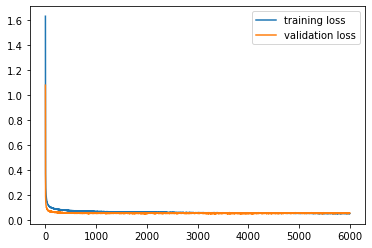

In [17]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.legend(['training loss','validation loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [18]:
#test loss
ep=5800
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
predtest=np.array([])
with torch.no_grad():
    model.cuda()
    model.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allstats[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
            labels=torch.tensor(alllabels[testIdx_i]).cuda().long()
        pred = model(testInput)
        predtest=np.concatenate((predtest,np.argmax(pred.cpu().detach().numpy(),axis=1)))
        
        loss_test=lossCE(pred,labels).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
    
print(loss_test_all)

0.05427918117493391


In [19]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()
    
plotCTcomp(alllabels[testIdx],predtest,plotsavepath,'confusion_test',False)

In [20]:
#train loss
ep=5800
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
predtrain=np.array([])
with torch.no_grad():
    model.cuda()
    model.eval()
    loss_train_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allstats[trainIdx_i])
        if use_cuda:
            trainInput=trainInput.cuda().float()
            labels=torch.tensor(alllabels[trainIdx_i]).cuda().long()
        pred = model(trainInput)
        predtrain=np.concatenate((predtrain,np.argmax(pred.cpu().detach().numpy(),axis=1)))
        
        loss_train=lossCE(pred,labels).item()

        loss_train_all+=loss_train

    loss_train_all=loss_train_all/ntrainBatches
    
print(loss_train_all)
plotCTcomp(alllabels[trainIdx],predtrain,plotsavepath,'confusion_train',False)

0.028236948242732162


In [23]:
stats_s=pd.read_csv(path_s)
stats_s.index=stats_s.loc[:,'label']
stats_s.columns[2:-2][np.isnan(allstats[0].astype(float))]

Index([], dtype='object')

## stats_s=pd.read_csv(path_s)


In [ ]:
stats_s.index=stats_s.loc[:,'label']
stats_s.columns[2:-2][np.isnan(allstats[1].astype(float))]